In [1]:
import pymc3 as pm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

In [2]:
# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

(array([ 2.,  1.,  6.,  5.,  4.,  4.,  8.,  9.,  6., 12., 11.,  7.,  9.,
         6.,  1.,  4.,  3.,  0.,  1.,  1.]),
 array([-2.42854948, -2.0593005 , -1.69005152, -1.32080254, -0.95155356,
        -0.58230458, -0.2130556 ,  0.15619338,  0.52544236,  0.89469134,
         1.26394032,  1.63318931,  2.00243829,  2.37168727,  2.74093625,
         3.11018523,  3.47943421,  3.84868319,  4.21793217,  4.58718115,
         4.95643013]),
 <a list of 20 Patch objects>)

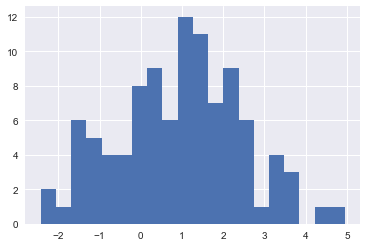

In [3]:
plt.hist(Y, bins=20);

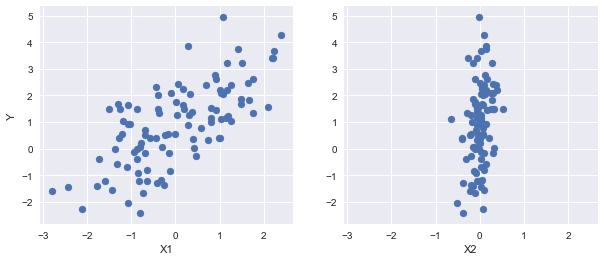

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

In [6]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

### Maximum a posteriori methods

The maximum a posteriori (MAP) estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn’t representative of the distribution.

In [9]:
map_estimate = pm.find_MAP(model=basic_model)

map_estimate

logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 765.66it/s]  


{'alpha': array(0.90660093),
 'beta': array([0.94848596, 2.60711845]),
 'sigma': array(0.96298858),
 'sigma_log__': array(-0.03771373)}

It is important to note that the MAP estimate is not always reasonable, especially if the mode is at an extreme. This can be a subtle issue; with high dimensional posteriors, one can have areas of extremely high density but low total probability because the volume is very small. This will often occur in hierarchical models with the variance parameter for the random effect. If the individual group means are all the same, the posterior will have near infinite density if the scale parameter for the group means is almost zero, even though the probability of such a small scale parameter will be small since the group means must be extremely close together.

Most techniques for finding the MAP estimate also only find a local optimum (which is often good enough), but can fail badly for multimodal posteriors if the different modes are meaningfully different.

### Sampling methods

Instead, a simulation-based approach such as Markov chain Monte Carlo (MCMC) can be used to obtain a Markov chain of values that, given the satisfaction of certain conditions, are indistinguishable from samples from the true posterior distribution.

PyMC3’s most capable step method is the No-U-Turn Sampler. NUTS is especially useful on models that have many continuous parameters, a situation where other MCMC algorithms work very slowly. It takes advantage of information about where regions of higher probability are, based on the gradient of the log posterior-density. This helps it achieve dramatically faster convergence on large problems than traditional sampling methods achieve. 

NUTS requires a scaling matrix parameter, which is analogous to the variance parameter for the jump proposal distribution in Metropolis-Hastings, although NUTS uses it somewhat differently. The matrix gives the rough shape of the distribution so that NUTS does not make jumps that are too large in some directions and too small in other directions. It is important to set this scaling parameter to a reasonable value to facilitate efficient sampling. This is especially true for models that have many unobserved stochastic random variables or models with highly non-normal posterior distributions. Poor scaling parameters will slow down NUTS significantly, sometimes almost stopping it completely. A reasonable starting point for sampling can also be important for efficient sampling, but not as often.

PyMC3 automatically initializes NUTS to reasonable values based on the variance of the samples obtained during a tuning phase. A little bit of noise is added to ensure different, parallel, chains start from different points.

In [23]:
with basic_model:

    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:17<00:00, 643.23draws/s]


In [24]:
trace['alpha'][-5:]

array([0.91730638, 0.92422374, 0.92173868, 0.95039338, 1.01727985])

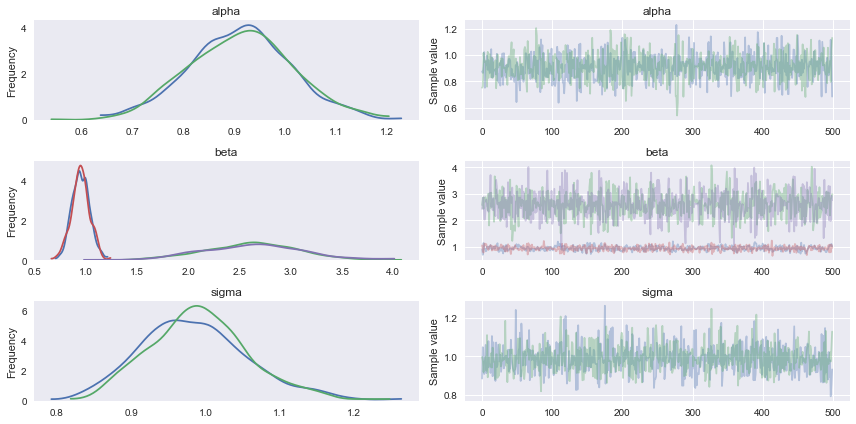

In [34]:
pm.traceplot(trace);

In [26]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 652.76draws/s] 


In [27]:
trace['alpha'][-5:]

array([0.89878914, 0.95472338, 0.79624342, 1.02873212, 1.12982286])

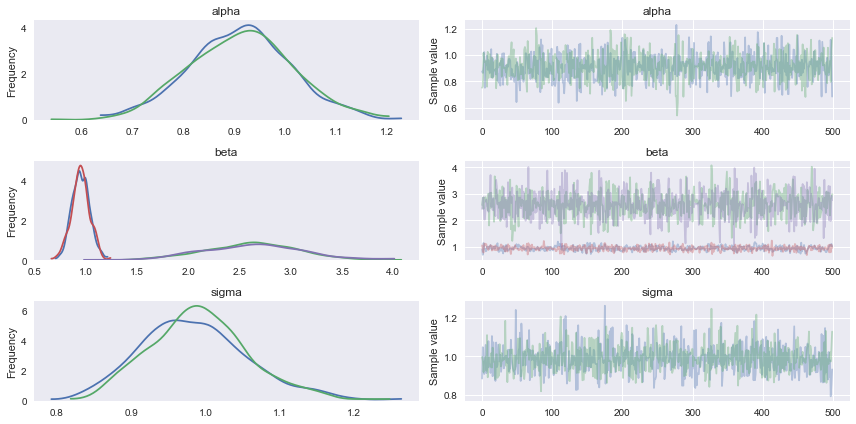

In [35]:
pm.traceplot(trace);

In [30]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.91,0.10,0.00,0.70,1.10,1507.23,1.0
beta__0,0.95,0.09,0.00,0.77,1.12,1052.21,1.0
beta__1,2.61,0.49,0.01,1.67,3.61,1557.38,1.0
sigma,0.99,0.07,0.00,0.86,1.14,1199.68,1.0


### Case study 1: Stochastic volatility

In [31]:
from pandas_datareader import data

In [32]:
import pandas as pd

returns = data.get_data_yahoo('SPY', start='2008-5-1', end='2009-12-1')['Close'].pct_change()

len(returns)

401

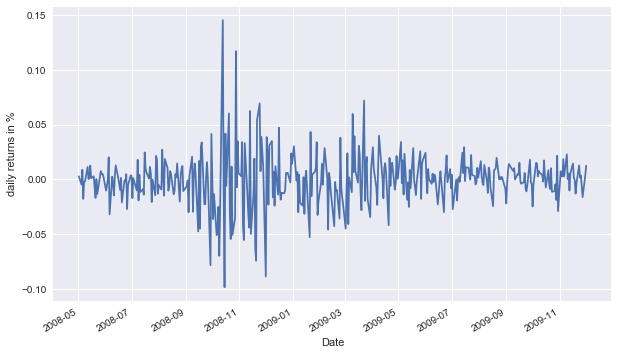

In [33]:
returns.plot(figsize=(10, 6))
plt.ylabel('daily returns in %');

In [40]:
with pm.Model() as sp500_model:
    nu = pm.Exponential('nu', 0.1, testval=5)
    sigma = pm.Exponential('sigma', 50, testval=.1)

    s = pm.GaussianRandomWalk('s', sd=sigma, shape=len(returns))
    volatility_process = pm.Deterministic('volatility_process', pm.math.exp(-2*s)**0.5)

    r = pm.StudentT('r', nu=nu, sd=volatility_process, observed=returns)

In [41]:
with sp500_model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [r_missing, s, sigma, nu]
Sampling 2 chains: 100%|██████████| 5000/5000 [03:02<00:00, 27.34draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


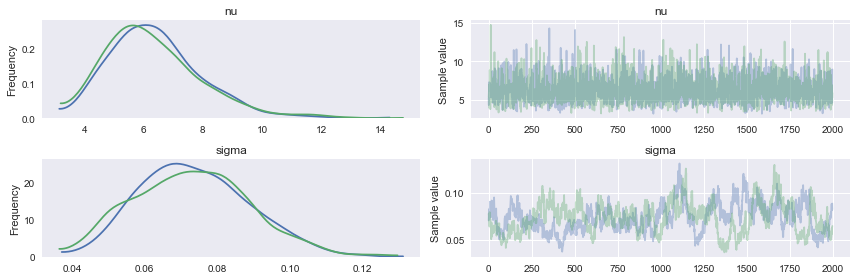

In [42]:
pm.traceplot(trace, varnames=['nu', 'sigma']);

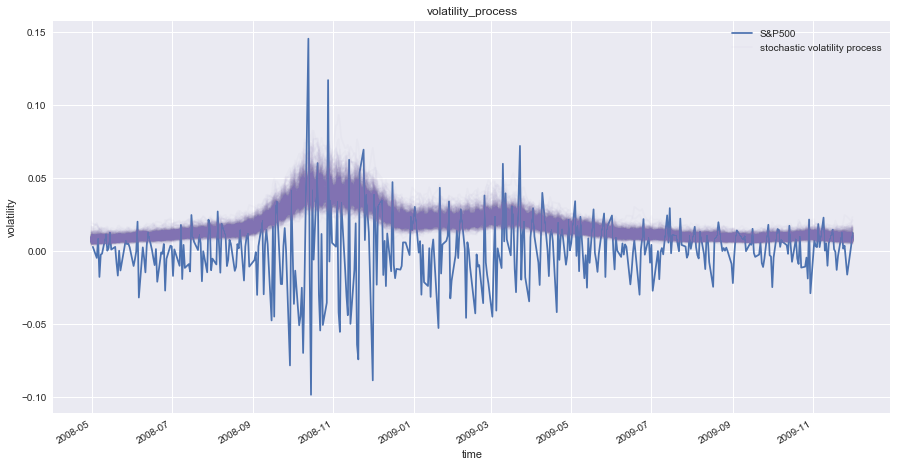

In [43]:
fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)
ax.plot(returns.index, 1/np.exp(trace['s',::5].T), 'C3', alpha=.03);
ax.set(title='volatility_process', xlabel='time', ylabel='volatility');
ax.legend(['S&P500', 'stochastic volatility process']);

### Case study 2: Coal mining disasters

Consider the following time series of recorded coal mining disasters in the UK from 1851 to 1962 (Jarrett, 1979). The number of disasters is thought to have been affected by changes in safety regulations during this period. Unfortunately, we also have pair of years with missing data, identified as missing by a NumPy MaskedArray using -999 as the marker value.

Next we will build a model for this series and attempt to estimate when the change occurred. At the same time, we will see how to handle missing data, use multiple samplers and sample from discrete random variables.

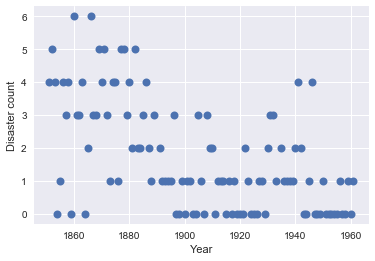

In [61]:
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year");

Occurrences of disasters in the time series is thought to follow a Poisson process with a large rate parameter in the early part of the time series, and from one with a smaller rate in the later part. We are interested in locating the change point in the series, which perhaps is related to changes in mining safety regulations.

In [64]:
with pm.Model() as disaster_model:
    switchpoint = pm.DiscreteUniform('switchpoint', 
                                     lower=years.min(), upper=years.max(), 
                                     testval=int(years.mean()))

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

Missing values are handled transparently by passing a MaskedArray or a pandas.DataFrame with NaN values to the observed argument when creating an observed stochastic random variable. Behind the scenes, another random variable, disasters.missing_values is created to model the missing values. All we need to do to handle the missing values is ensure we sample this random variable as well.

In [69]:
with disaster_model:
    trace = pm.sample(10000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:20<00:00, 1020.86draws/s]
The number of effective samples is smaller than 10% for some parameters.


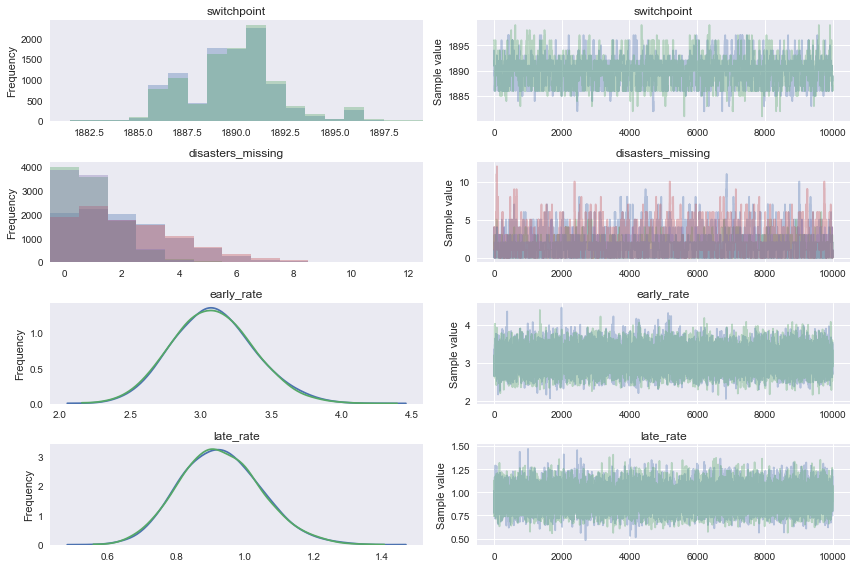

In [70]:
pm.traceplot(trace);

In the trace plot we can see that there’s about a 10 year span that’s plausible for a significant change in safety, but a 5 year span that contains most of the probability mass. The distribution is jagged because of the jumpy relationship between the year switchpoint and the likelihood and not due to sampling error.

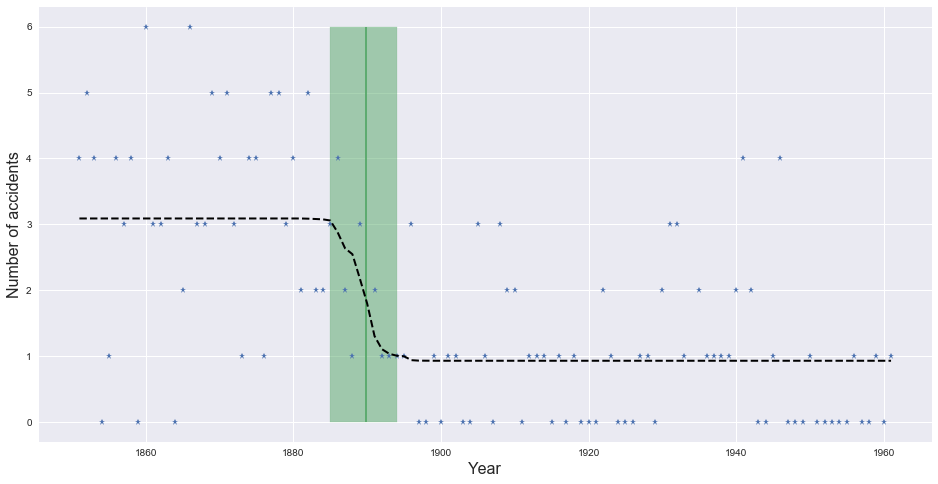

In [81]:
plt.figure(figsize=(16, 8))
plt.plot(years, disaster_data, '*')
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

plt.vlines(trace['switchpoint'].mean(), 
           disaster_data.min(), disaster_data.max(), 
           color='C1')

average_disasters = np.zeros_like(disaster_data, dtype='float')
for i, year in enumerate(years):
    idx = year < trace['switchpoint']
    average_disasters[i] = (trace['early_rate'][idx].sum() + trace['late_rate'][~idx].sum()) / (len(trace) * trace.nchains)

# Confidence interval
sp_hpd = pm.hpd(trace['switchpoint'])
plt.fill_betweenx(y=[disaster_data.min(), disaster_data.max()],
                  x1=sp_hpd[0], x2=sp_hpd[1], 
                  alpha=0.5, color='C1');

# average disasters (black line)
plt.plot(years, average_disasters,  'k--', lw=2);

Also supports
* Arbitrary deterministics functions

* Arbitrary distributions

In [82]:
df = pd.DataFrame({'x1': X1, 'x2': X2, 'y': Y})

In [89]:
from pymc3.glm import GLM

with pm.Model() as model_glm:
    GLM.from_formula('y ~ x1 + x2', df)
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x2, x1, Intercept]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:14<00:00, 1426.82draws/s]


In [90]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,0.91,0.10,0.0,0.71,1.10,34087.64,1.0
x1,0.95,0.09,0.0,0.78,1.12,26718.65,1.0
x2,2.61,0.51,0.0,1.63,3.65,31123.74,1.0
sd,1.00,0.07,0.0,0.86,1.14,28696.81,1.0


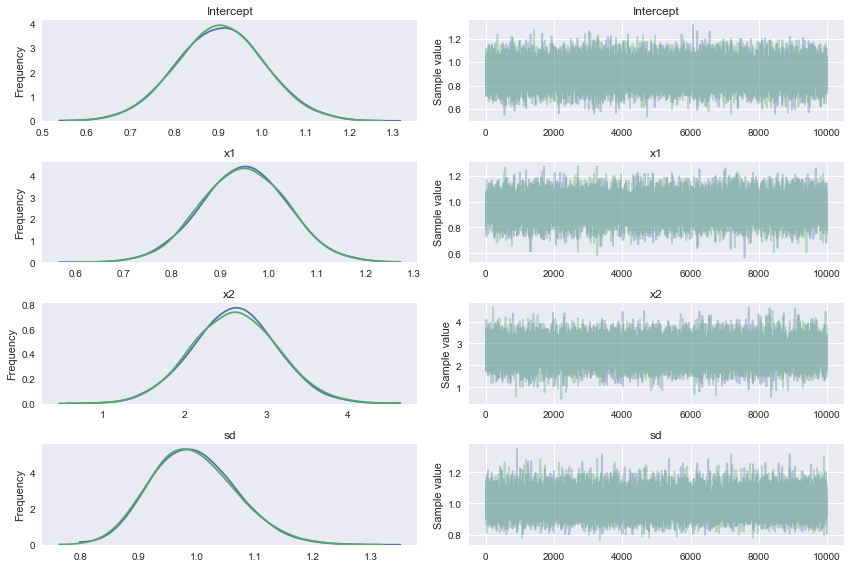

In [91]:
pm.traceplot(trace);

In [94]:
from pymc3.glm.families import Binomial

df_logistic = pd.DataFrame({'x1': X1, 'y': Y > np.median(Y)})

with pm.Model() as model_glm_logistic:
    GLM.from_formula('y ~ x1', df_logistic, family=Binomial())
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x1, Intercept]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:12<00:00, 1628.77draws/s]


In [95]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-0.02,0.24,0.0,-0.50,0.47,21120.08,1.0
x1,1.41,0.28,0.0,0.87,1.97,19211.79,1.0


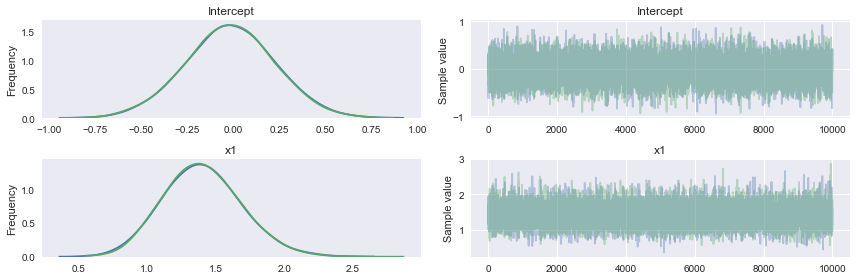

In [96]:
pm.traceplot(trace);